# Class-Conditional Synthesis with Latent Diffusion Models

Install all the requirements

In [1]:
# #@title Installation
# !git clone https://github.com/CompVis/latent-diffusion.git
# !git clone https://github.com/CompVis/taming-transformers
# !pip install -e ./taming-transformers
# !pip install omegaconf>=2.0.0 pytorch-lightning>=1.0.8 torch-fidelity einops

import os
import sys

cwd = os.getcwd()
sys.path.append(".")
# sys.path.append('./taming-transformers')
from taming.models import vqgan 

c:\ProgramData\Anaconda3\envs\thesis\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: [WinError 127] The specified procedure could not be found
  warn(f"Failed to load image Python extension: {e}")


Now, download the checkpoint (~1.7 GB). This will usually take 1-2 minutes.

In [6]:
# #@title Download
# %cd latent-diffusion/ 

# !mkdir -p models/ldm/cin256-v2/
# !wget -O models/ldm/cin256-v2/model.ckpt https://ommer-lab.com/files/latent-diffusion/nitro/cin/model.ckpt 

[WinError 2] The system cannot find the file specified: 'latent-diffusion/'
d:\OneDrive\Uni\Master_Project_AI\Master_Thesis\Diffusion_Thesis\pretrained\class_imagenet\latent-diffusion


The syntax of the command is incorrect.
'wget' is not recognized as an internal or external command,
operable program or batch file.


Let's also check what type of GPU we've got.

In [7]:
!nvidia-smi

Wed Mar  1 17:39:38 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 528.49       Driver Version: 528.49       CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:07:00.0  On |                  N/A |
|  0%   52C    P8    19W / 170W |   1658MiB / 12288MiB |     29%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

Load it.

In [3]:
#@title loading utils
import torch
from omegaconf import OmegaConf

from ldm.util import instantiate_from_config


def load_model_from_config(config, ckpt):
    print(f"Loading model from {ckpt}")
    pl_sd = torch.load(ckpt)#, map_location="cpu")
    sd = pl_sd["state_dict"]
    model = instantiate_from_config(config.model)
    m, u = model.load_state_dict(sd, strict=False)
    model.cuda()
    model.eval()
    return model


def get_model():
    config = OmegaConf.load("configs/latent-diffusion/cin256-v2.yaml")  
    model = load_model_from_config(config, "models/ldm/cin256-v2/model.ckpt")
    return model

ModuleNotFoundError: No module named 'ldm'

In [11]:
from ldm.models.diffusion.ddim import DDIMSampler

model = get_model()
sampler = DDIMSampler(model)

Loading model from models/ldm/cin256-v2/model.ckpt
LatentDiffusion: Running in eps-prediction mode
DiffusionWrapper has 400.92 M params.
making attention of type 'vanilla' with 512 in_channels
Working with z of shape (1, 3, 64, 64) = 12288 dimensions.
making attention of type 'vanilla' with 512 in_channels


And go. Quality, sampling speed and diversity are best controlled via the `scale`, `ddim_steps` and `ddim_eta` variables. As a rule of thumb, higher values of `scale` produce better samples at the cost of a reduced output diversity. Furthermore, increasing `ddim_steps` generally also gives higher quality samples, but returns are diminishing for values > 250. Fast sampling (i e. low values of `ddim_steps`) while retaining good quality can be achieved by using `ddim_eta = 0.0`.

rendering 6 examples of class '25' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:10<00:00,  2.00it/s]


rendering 6 examples of class '187' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


rendering 6 examples of class '448' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


rendering 6 examples of class '992' in 20 steps and using s=3.00.
Data shape for DDIM sampling is (6, 3, 64, 64), eta 0.0
Running DDIM Sampling with 20 timesteps


DDIM Sampler: 100%|██████████| 20/20 [00:07<00:00,  2.74it/s]


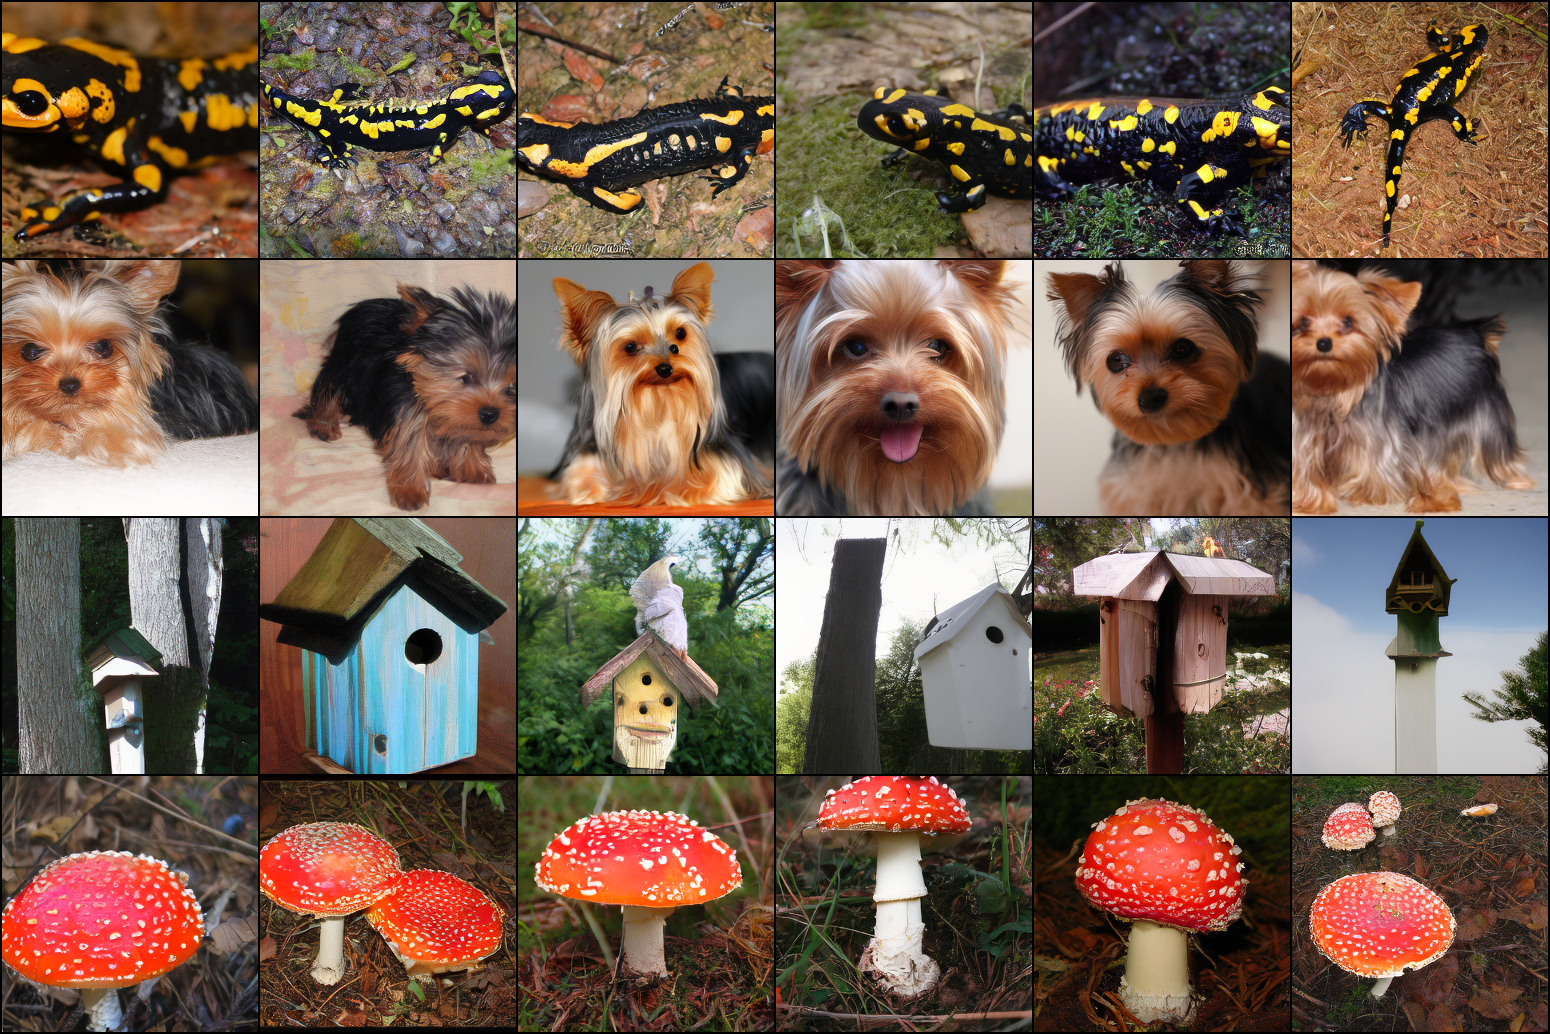

In [12]:
import numpy as np 
from PIL import Image
from einops import rearrange
from torchvision.utils import make_grid


classes = [25, 187, 448, 992]   # define classes to be sampled here
n_samples_per_class = 6

ddim_steps = 20
ddim_eta = 0.0
scale = 3.0   # for unconditional guidance


all_samples = list()

with torch.no_grad():
    with model.ema_scope():
        uc = model.get_learned_conditioning(
            {model.cond_stage_key: torch.tensor(n_samples_per_class*[1000]).to(model.device)}
            )
        
        for class_label in classes:
            print(f"rendering {n_samples_per_class} examples of class '{class_label}' in {ddim_steps} steps and using s={scale:.2f}.")
            xc = torch.tensor(n_samples_per_class*[class_label])
            c = model.get_learned_conditioning({model.cond_stage_key: xc.to(model.device)})
            
            samples_ddim, _ = sampler.sample(S=ddim_steps,
                                             conditioning=c,
                                             batch_size=n_samples_per_class,
                                             shape=[3, 64, 64],
                                             verbose=False,
                                             unconditional_guidance_scale=scale,
                                             unconditional_conditioning=uc, 
                                             eta=ddim_eta)

            x_samples_ddim = model.decode_first_stage(samples_ddim)
            x_samples_ddim = torch.clamp((x_samples_ddim+1.0)/2.0, 
                                         min=0.0, max=1.0)
            all_samples.append(x_samples_ddim)


# display as grid
grid = torch.stack(all_samples, 0)
grid = rearrange(grid, 'n b c h w -> (n b) c h w')
grid = make_grid(grid, nrow=n_samples_per_class)

# to image
grid = 255. * rearrange(grid, 'c h w -> h w c').cpu().numpy()
Image.fromarray(grid.astype(np.uint8))